# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.interpolate import interp1d
from scipy.optimize import minimize
sys.path.append('documents/BNL/jupyter/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='/home/anze/work/lusee/Drive/'
from algorithms import  Comb, Calibrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# load in luseepy
current_dir = os.getcwd()

# Get the path to BNL/jupyter directory
jupyter_dir = os.path.abspath(os.path.join(current_dir, '../..'))
# Append the jupyter directory to the system path
sys.path.append(jupyter_dir)

import luseepy
from luseepy import lusee

In [39]:
B=lusee.Beam()


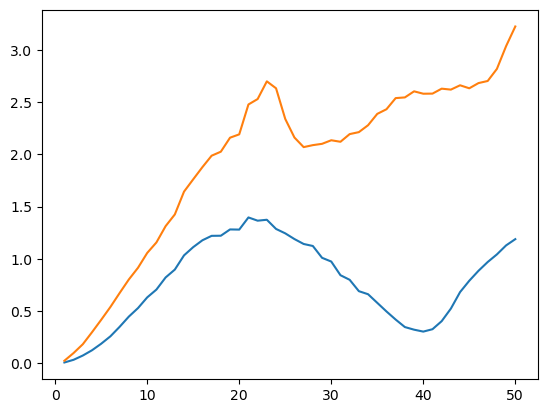

In [40]:
medgain = [np.median(B.gain[i,:,:]) for i in np.arange(len(B.freq))]
maxgain = [np.max(B.gain[i,:,:]) for i in np.arange(len(B.freq))]
plt.plot(B.freq,medgain)
plt.plot(B.freq,maxgain)

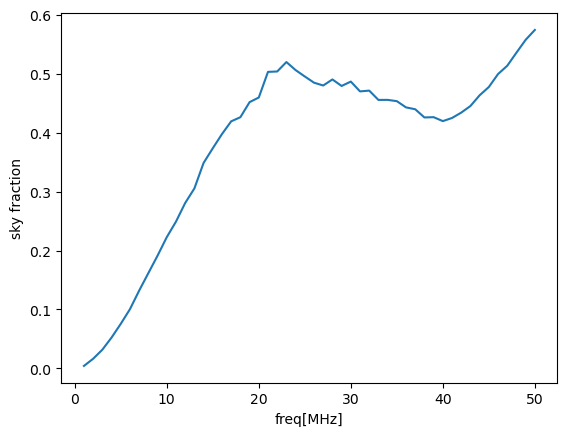

In [41]:

plt.plot(B.freq,B.sky_fraction())
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear')




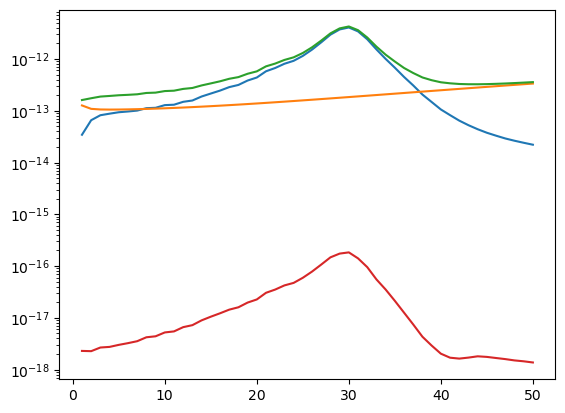

In [42]:
T=lusee.Throughput()

B2T = 3e8**2/(2*1.38e-23*B.freq**2)
Nsky = np.array(T.T2Vsq(B.freq)*lusee.MonoSkyModels.T_NB(B.freq)*sky_fraction(B.freq)*25e3)
Namp = np.array(T.noise(B.freq)*25e3)
Bw = 100e3/400 # as per gina
lmb = 3e8/(B.freq*1e6)
X = lmb**2/(4*np.pi)*medgain
kb = 1.38e-23
A = np.array(np.ones(len(B.freq))*1e-22*Bw*X*T.T2Vsq(B.freq)/kb)
plt.plot(B.freq,Nsky)
plt.plot(B.freq,Namp)
plt.plot(B.freq,Nsky+Namp)
plt.plot(B.freq,A)
plt.semilogy()
Ai = interp1d(B.freq,A,kind='linear')
Ni = interp1d(B.freq,Nsky+Namp,kind='linear')



In [43]:
kar = np.arange(181,181+410*2,2)
freq = kar*50e3
print (freq.min(),freq.max(),len(freq))
As = np.sqrt(Ai(freq/1e6)) # amplitude not power
Ns = np.sqrt(Ni(freq/1e6)) # sigma not sigma^2

9050000.0 49950000.0 410


In [44]:
np.save('As.npy',As)
np.save('Ns.npy',Ns)
np.save('kar',kar)

In [46]:
precompensation = np.load('precompensation.npz')['precomp'][90:90+410]
precompensation /= precompensation.sum()
antenna = 1/np.copy(precompensation)
freq=(kar*50e3)/1e6

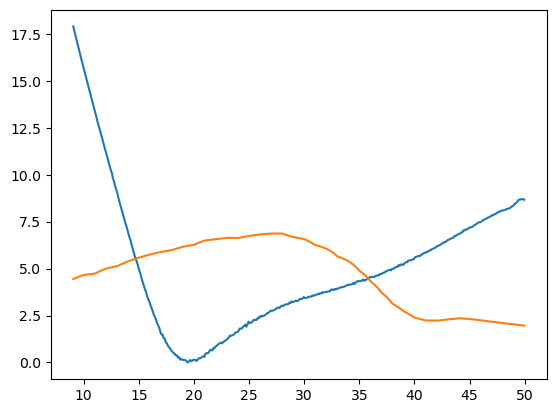

In [49]:
plt.plot(freq,np.log10(precompensation/precompensation.min())*10)
plt.plot(freq,As/Ns*1000)

In [87]:
precompensation_fix = np.copy(precompensation)
precompensation_fix[freq<18]*=0.01
precompensation_fix[(freq>=25)]*=0.01
istart = 270
istep = 8
precompensation_fix[istart+0::istep]*=8
for j in range(1,step):
    precompensation_fix[istart+j::istep]*=0

precompensation_fix/=precompensation_fix.sum()

precompensation_fix2 = 1/np.copy(precompensation)**2
precompensation_fix2/=precompensation_fix2.sum()


410.0 1512.710024684053


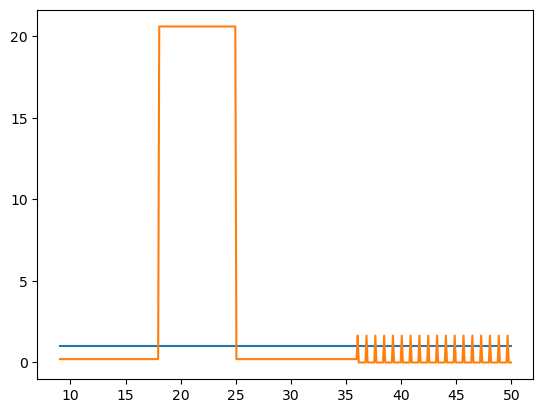

In [88]:
plt.plot(freq,precompensation*antenna)
plt.plot(freq,precompensation_fix*antenna)
print ((precompensation*antenna).sum(),(precompensation_fix*antenna).sum())


In [89]:
Asfix = As*np.sqrt(precompensation_fix*antenna)
np.save('Asfix.npy',Asfix)

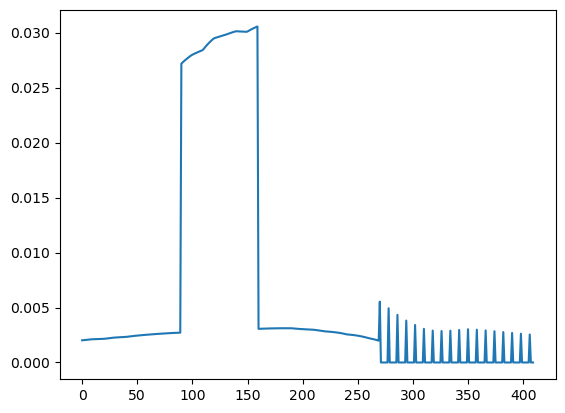

In [90]:
plt.plot(Asfix/Ns)

In [127]:
comb=Comb(kar,response=Asfix, noise=Ns*0.1)
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.01, add_noise=True)
res = C.analyze_data(alpha_start=0.3,tmax=30,force_detect=False)
res['detect'], res['SNR2']

FD mean: -81133.31237928713 SD mean: -217406726278.46295
1.0053096491487338e-05


(array([False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

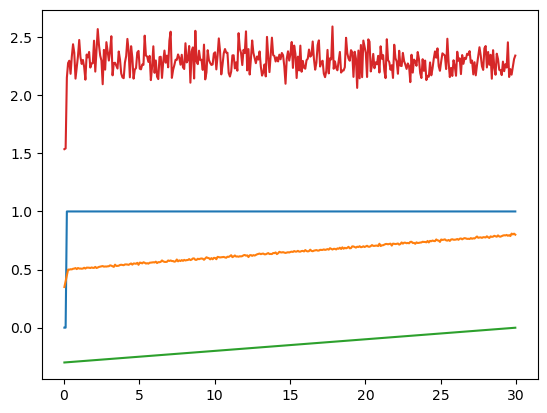

In [128]:
t = res['t']
plt.plot(t,res['detect'])
plt.plot(t,res['alphadet'])
plt.plot(t,-res['alpha'])
plt.plot(t,res['SNR2']/400)

In [ ]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms,pilot_idx=[300],pilot_boost=15)
C = Calibrator(comb, alpha=-0.4,dalpha_dt=0.0, add_noise=True, Nnotch=256, Nintg=4)
wb,nb = C.analyze_data_incoherent()

In [ ]:
plt.plot(nb/wb)
